In [1]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import seaborn as sns
from pyMRI.utils import RMSE

In [2]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i : met_i+1], t2s[met_i : met_i+1], M_0s[met_i : met_i+1]
spins_phi = np.zeros_like(M_0s)

print("Freqs (rad/s),\t\t T_2s (s),\t M_0s (U.A.),\t phis (rad)")
print(ws, "\t", t2s, "\t", M_0s, "\t", spins_phi)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

Freqs (rad/s),		 T_2s (s),	 M_0s (U.A.),	 phis (rad)
[2411.71251655] 	 [0.0735] 	 [0.4289] 	 [0.]
All frequencies are captured by the sampling rate.


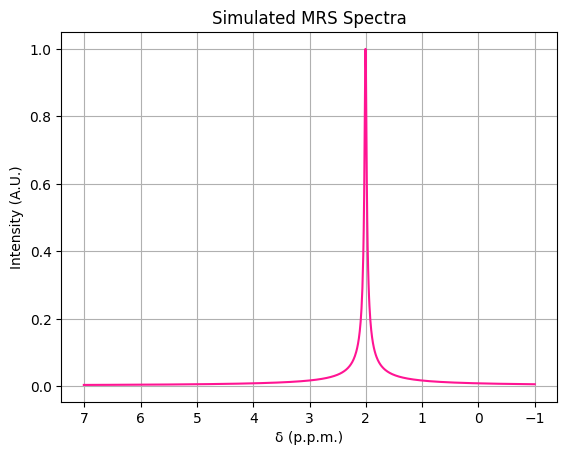

In [3]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
sig_fft = sig_fft/np.max(sig_fft)
sig = np.fft.ifft(np.fft.ifftshift(sig_fft))

pymri.plot_chem_shifts(freqs, sig_fft)

In [4]:
L = 0.4
noise_threshold = 30
L_ = int(L*sig.size)

In [5]:
_, z_, r_ = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True)
original_s0s, original_phis, original_omegas, original_t2s = pymri.calculate_variables_from_z_and_r(z_, r_, dt)
original_t2s = 1/original_t2s

In [6]:
print(original_s0s)

[0.00664024]


In [9]:
SNR = 1.0
loc = 0.0
scale = 0.05

In [10]:
noise = np.random.normal(loc, scale, 2048) + 1j*np.random.normal(loc, scale, 2048)
c_sig_fft = sig_fft + noise
print(pymri.snr(c_sig_fft))

12.666620708499925


([], [])

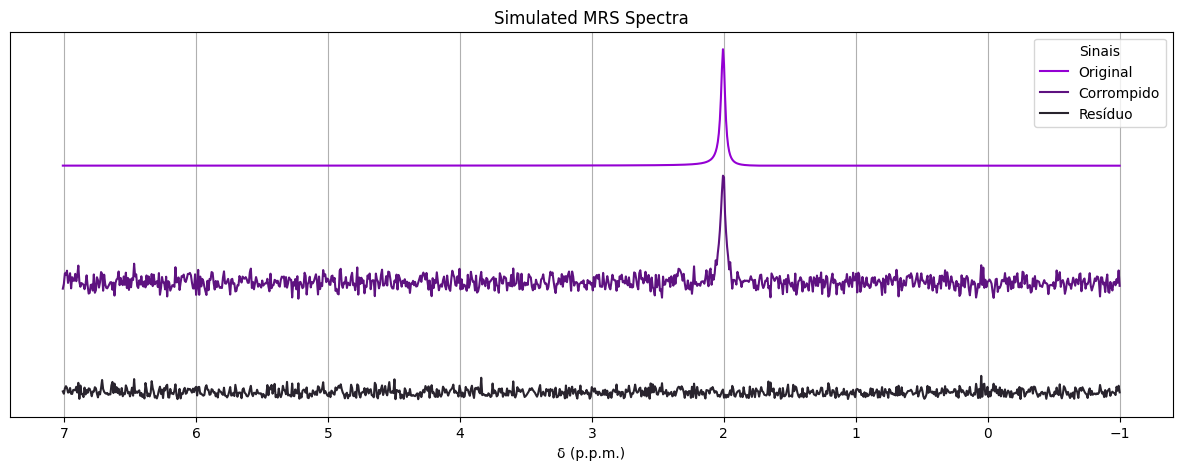

In [ ]:
c_sig = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

y_offset = 1.0
palette = sns.dark_palette("#9400D3", n_colors= 3, reverse = True)

plt.figure(figsize = (15, 5))
pymri.sns_plot_chem_shifts(freqs = np.array([freqs, freqs, freqs]), 
                           sig_fft = np.array([sig_fft + 2*y_offset, c_sig_fft + y_offset, c_sig_fft - sig_fft]), 
                           hue = np.array( [["Original"]*sig_fft.size, ["Corrompido"]*sig_fft.size, ["Resíduo"]*sig_fft.size]),
                           hue_label = "Sinais",
                           palette=palette)
plt.ylabel("")
plt.yticks([])


In [56]:
_, z, r = pymri.filter_sig(c_sig, L, noise_threshold, rcond=1e-15, return_poles_and_res=True)
s0s_, phis_, omegas_, t2s_ = pymri.calculate_variables_from_z_and_r(z, r, dt)
t2s_ = 1/t2s_

In [13]:
def filter_omegas(omegas : np.ndarray, dt : float):
    """Filters a given set of calculated omegas based on the Nyquist Frequency.
    
    Parameters
    ----------
    omegas : np.ndarray [rad/s]
        Array of omegas.
    dt : float [s]
        Time step of the simulation.
        
    Returns
    -------
    filtered_omegas : np.ndarray
        Boolean array that identifies the true frequencies of the omega array."""
    limit_omega = pymri.max_frequency(dt)
    return pymri.rad_to_hz(omegas) <= limit_omega

def filter_t2(t2s : np.ndarray, upper_bound : float = 0.5, lower_bound : float = -4.0):
    """Filters a given set of calculated T2s based on its physicial meaning.
    
    Parameters
    ----------
    t2s : np.ndarray
        T2s array.
    upper_bound : float = `0.5`
        Maximum order a T2 can have.
    lower_bound : float `-4.0`
        Minimum order a T2 can have.
    
    Returns 
    -------
    t2_filter_array : np.ndarray
        Boolean array that identifies the actual possible T2s."""
    lower_order_arr = np.log10(np.abs(t2s)) >= lower_bound
    higher_order_arr = np.log10(np.abs(t2s)) < upper_bound
    negative_arr = t2s >= 0.0
    t2_filter_arr = np.bitwise_and( np.bitwise_and( lower_order_arr, higher_order_arr), negative_arr)
    return t2_filter_arr


def compose_filters(filters : tuple):
    """Composes a set of given filters into one final filter.
    
    Parameters
    ----------
    filters : tuple
        The set of filters to be composed.
        
    Returns
    -------
    final_filter : np.ndarray
        The composition of all the filters."""
    
    n = len(filters)

    final_filter = np.full(filters[0].shape, True, dtype = bool)

    for i in range(n):
        final_filter = np.bitwise_and(final_filter, filters[i])

    return final_filter

In [57]:
omega_filter = filter_omegas(omegas_, dt)
t2_filter = filter_t2(t2s_)

filter = compose_filters((omega_filter, t2_filter))

print("Freqs filtradas \t Total")
print(omegas_[omega_filter].size, "\t\t\t", omegas_.size)
print("T2s filtrados \t Total")
print(omegas_[t2_filter].size, "\t\t\t", omegas_.size)
print("Total filtrados \t Total")
print(omegas_[filter].size, "\t\t\t", omegas_.size)

Freqs filtradas 	 Total
409 			 819
T2s filtrados 	 Total
685 			 819
Total filtrados 	 Total
342 			 819


In [59]:
filtered_s0 =  s0s_[filter]
filtered_phi = phis_[filter]
filtered_omega = omegas_[filter]
filtered_t2 = t2s_[filter]

In [60]:
filtered_pop = pymri.population(filtered_omega, filtered_t2, filtered_s0, filtered_phi)

filtered_sig, t = pymri.population_transverse_decay( t0, tn, dt, filtered_pop)
freqs, filtered_sig_fft = pymri.fourier_spectrum( filtered_sig, dt, B0 )

([], [])

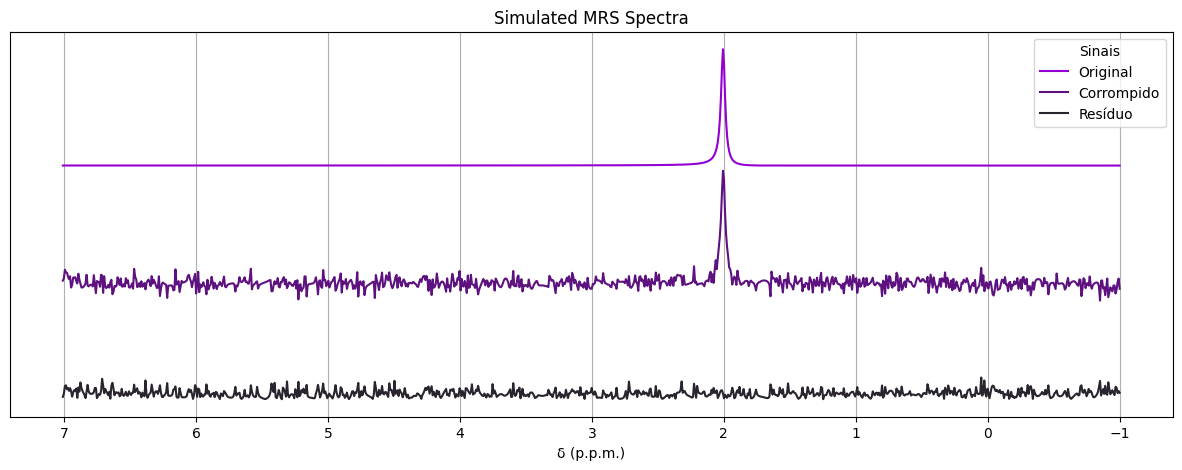

In [61]:
y_offset = 1.0
palette = sns.dark_palette("#9400D3", n_colors= 3, reverse = True)

plt.figure(figsize = (15, 5))
pymri.sns_plot_chem_shifts(freqs = np.array([freqs, freqs, freqs]), 
                           sig_fft = np.array([sig_fft + 2*y_offset, filtered_sig_fft + y_offset, filtered_sig_fft - sig_fft]), 
                           hue = np.array( [["Original"]*sig_fft.size, ["Corrompido"]*sig_fft.size, ["Resíduo"]*sig_fft.size]),
                           hue_label = "Sinais",
                           palette=palette)
plt.ylabel("")
plt.yticks([])

In [62]:
_, z, r = pymri.filter_sig(filtered_sig, L, noise_threshold, rcond=1e-7, return_poles_and_res=True, return_full_arrays=True)
s0s_2, phis_2, omegas_2, t2s_2 = pymri.calculate_variables_from_z_and_r(z, r, dt)
t2s_2 = 1/t2s_2

In [63]:
print(s0s_2.shape)

(819,)


In [64]:
omega_filter = filter_omegas(omegas_2, dt)
t2_filter = filter_t2(t2s_2)

filter = compose_filters((omega_filter, t2_filter))

print("Freqs filtradas \t Total")
print(omegas_2[omega_filter].size, "\t\t\t", omegas_2.size)
print("T2s filtrados \t Total")
print(omegas_2[t2_filter].size, "\t\t\t", omegas_2.size)
print("Total filtrados \t Total")
print(omegas_2[filter].size, "\t\t\t", omegas_2.size)

Freqs filtradas 	 Total
688 			 819
T2s filtrados 	 Total
342 			 819
Total filtrados 	 Total
342 			 819


C:\Users\Lampada\AppData\Local\Temp\ipykernel_55664\3079009280.py:34: RuntimeWarning: divide by zero encountered in log10
  lower_order_arr = np.log10(np.abs(t2s)) >= lower_bound
C:\Users\Lampada\AppData\Local\Temp\ipykernel_55664\3079009280.py:35: RuntimeWarning: divide by zero encountered in log10
  higher_order_arr = np.log10(np.abs(t2s)) < upper_bound


In [65]:
filtered_s0_2 =  s0s_2[filter]
filtered_phi_2 = phis_2[filter]
filtered_omega_2 = omegas_2[filter]
filtered_t2_2 = t2s_2[filter]

In [66]:
filtered_pop_2 = pymri.population(filtered_omega, filtered_t2, filtered_s0, filtered_phi)

filtered_sig_2, t = pymri.population_transverse_decay( t0, tn, dt, filtered_pop_2)
freqs, filtered_sig_fft_2 = pymri.fourier_spectrum( filtered_sig_2, dt, B0 )

([], [])

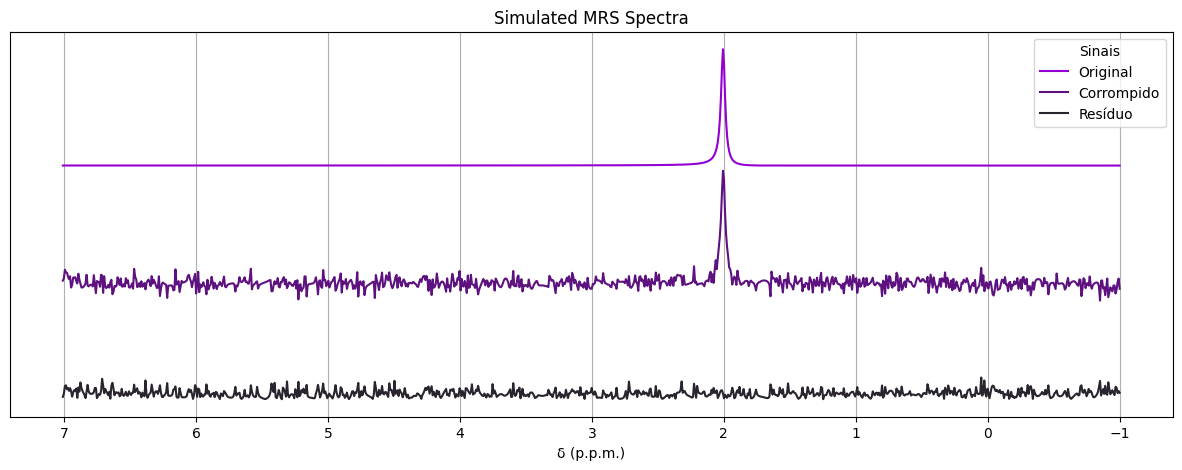

In [67]:
y_offset = 1.0
palette = sns.dark_palette("#9400D3", n_colors= 3, reverse = True)

plt.figure(figsize = (15, 5))
pymri.sns_plot_chem_shifts(freqs = np.array([freqs, freqs, freqs]), 
                           sig_fft = np.array([sig_fft + 2*y_offset, filtered_sig_fft_2 + y_offset, filtered_sig_fft_2 - sig_fft]), 
                           hue = np.array( [["Original"]*sig_fft.size, ["Corrompido"]*sig_fft.size, ["Resíduo"]*sig_fft.size]),
                           hue_label = "Sinais",
                           palette=palette)
plt.ylabel("")
plt.yticks([])